In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
!dvc pull
notebook_dir = os.getcwd()
data_path = os.path.join(notebook_dir, "..", "data", "MachineLearningRating_v3.txt")

df = pd.read_csv(data_path, delimiter="|")

Everything is up to date.


C:\Users\Bisrat\AppData\Local\Temp\ipykernel_2304\825271066.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, delimiter="|")


In [3]:
# Drop rows where target variables are missing
df = df.dropna(subset=["TotalClaims", "CalculatedPremiumPerTerm"])

In [4]:
# Target: has_claim (1 if TotalClaims > 0 else 0)
df["has_claim"] = df["TotalClaims"].apply(lambda x: 1 if x > 0 else 0)

# Define features and target
X = df.drop(columns=["TotalClaims", "CalculatedPremiumPerTerm", "has_claim"])
y = df["has_claim"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Select only numeric columns
X_train_num = X_train.select_dtypes(exclude=['object'])
X_test_num = X_test.select_dtypes(exclude=['object'])

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_num, y_train)

# Predict probabilities
claim_probs = clf.predict_proba(X_test_num)[:, 1]

# Evaluate
print("ROC-AUC:", roc_auc_score(y_test, claim_probs))
print(classification_report(y_test, clf.predict(X_test_num)))

ROC-AUC: 0.5867018561937145
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199439
           1       0.03      0.00      0.00       581

    accuracy                           1.00    200020
   macro avg       0.51      0.50      0.50    200020
weighted avg       0.99      1.00      1.00    200020



In [6]:
# Save for later merging with severity prediction
X_test_claim = X_test.copy()
X_test_claim["claim_prob"] = claim_probs
X_test_claim["actual_claim"] = y_test.values

In [8]:
# Predict severity for claimants using mean severity from training data as a placeholder
mean_severity = df.loc[df["has_claim"] == 1, "TotalClaims"].mean()
X_test_claim["predicted_severity"] = mean_severity

X_test_claim["expected_loss"] = X_test_claim["claim_prob"] * X_test_claim["predicted_severity"]


In [9]:
X_test_claim["optimized_premium"] = X_test_claim["expected_loss"] * 1.2  # 20% margin

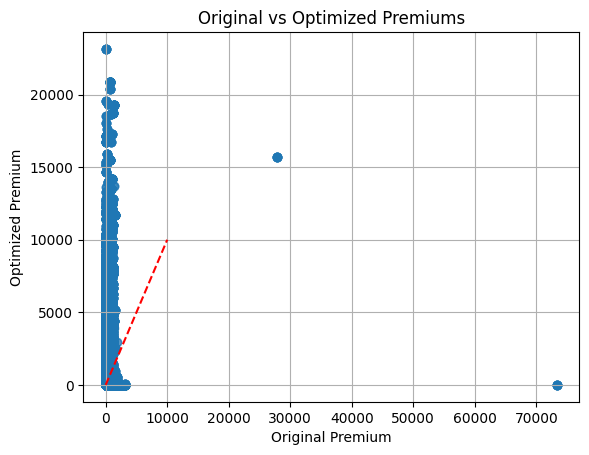

In [11]:
import matplotlib.pyplot as plt

# Merge CalculatedPremiumPerTerm from df into X_test_claim
if "CalculatedPremiumPerTerm" not in X_test_claim.columns:
	X_test_claim = X_test_claim.merge(
		df[["UnderwrittenCoverID", "PolicyID", "CalculatedPremiumPerTerm"]],
		on=["UnderwrittenCoverID", "PolicyID"],
		how="left"
	)

plt.scatter(X_test_claim["CalculatedPremiumPerTerm"], X_test_claim["optimized_premium"], alpha=0.5)
plt.xlabel("Original Premium")
plt.ylabel("Optimized Premium")
plt.title("Original vs Optimized Premiums")
plt.plot([0, 10000], [0, 10000], '--r')  # reference line
plt.grid(True)
plt.show()